In [ ]:
# default_exp search

# Search

> Functions related to the search

This notebook contains all functions related to searching and getting peptide-spectrum-matches (PSMs). When searching, we compare how similar an experimental spectrum is to a theoretical spectrum. As described in the FASTA notebook, we can calculate theoretical fragment masses for a given peptide sequence and get theoretical spectra. Typically, we calculate a database with all possible spectra and compare our experimental data. It could be that the database is too large to be saved on disc; here we keep the database in memory.

In [ ]:
#hide
import warnings
from numba import NumbaPendingDeprecationWarning

warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)

## Comparing Fragments

To efficiently compare two fragments, we use a pointer based approach. We start with two sorted arrays, the `query_frag` that contains the m/z positions of the query spectrum and the `db_frag` which contains the database fragment that is compared against to. The two pointers compare each m/z position with each other and check wheter they are within a certain tolerance `mtol`. Depending on their delta, either of the pointers is advanced. The function returns an arrray named `hits` that is the same length as the database spectrum and encodes the hit positions.

In [ ]:
#export
import logging
from numba import njit
import numpy as np

@njit(nogil=True)
def compare_frags(query_frag, db_frag, mtol, ppm=False):
    """
    Compare query and database frags and find hits
    """
    q_max = len(query_frag)
    d_max = len(db_frag)
    hits = np.zeros(d_max, dtype=np.int16)
    q, d = 0, 0  # q > query, d > database
    while q < q_max and d < d_max:
        mass1 = query_frag[q]
        mass2 = db_frag[d]
        delta_mass = mass1 - mass2

        if ppm:
            sum_mass = mass1 + mass2
            mass_difference = 2 * delta_mass / sum_mass * 1e6
        else:
            mass_difference = delta_mass

        if abs(mass_difference) <= mtol:
            hits[d] = q + 1  # Save query position +1 (zero-indexing)
            d += 1
            q += 1  # Only one query for each db element
        elif delta_mass < 0:
            q += 1
        elif delta_mass > 0:
            d += 1

    return hits

In [ ]:
import numpy as np
query_frag = np.array([100, 200, 300, 400])
db_frag = np.array([150, 200, 300, 450])

# Hits: Query 2 -> Db 2 and Query 3 -> Db 3

compare_frags(query_frag, db_frag, mtol=1)

array([0, 2, 3, 0], dtype=int16)

In [ ]:
#hide
def test_compare_frags():
    query_frag = np.array([100, 200, 300, 400])
    mtol = 1

    db_frag = query_frag.copy()

    # Self-Comparison: no of hits should be same as length
    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert np.sum(hits > 0) == len(query_frag)

    # Self-Comparison: above but in tolerance
    hits = compare_frags(query_frag, db_frag + mtol - 0.01, mtol, ppm=False)
    assert np.sum(hits > 0) == len(query_frag)

    # Self-Comparison: below but in tolerance
    hits = compare_frags(query_frag, db_frag - mtol + 0.01, mtol, ppm=False)
    assert np.sum(hits > 0) == len(query_frag)

    # Self-Comparison: above tolerance, no hits
    hits = compare_frags(query_frag, db_frag + mtol + 0.01, mtol, ppm=False)
    assert np.sum(hits > 0) == 0

    # Special case 1: First and last
    db_frag = np.array([100, 400])
    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert np.sum(hits > 0) == 2

    # Special case 2: Two queries matching the same DB frag
    query_frag = np.array([100, 100.5])
    db_frag = np.array([100, 200, 300])
    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert np.sum(hits > 0) == 1

    # Special case 3: Two db frags matching the same query frag
    db_frag = np.array([100, 100.5])
    query_frag = np.array([100, 200, 300])
    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert np.sum(hits > 0) == 1
    
test_compare_frags()

This function allows us to easily compare a query spectrum against a theoretical database.

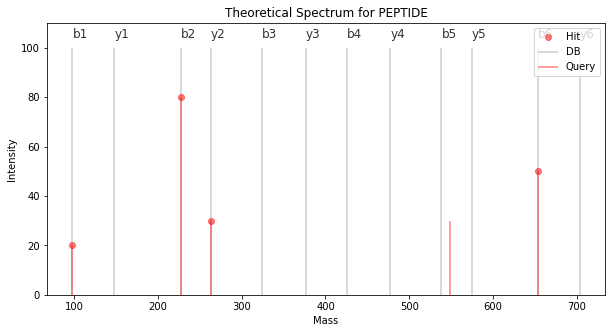

In [ ]:
import matplotlib.pyplot as plt
from alphapept import constants
from alphapept.fasta import get_frag_dict, parse
import alphapept.io
import numpy as np

%matplotlib inline
peptide = 'PEPTIDE'

# Theoretical Spectrum

frag_dict = get_frag_dict(parse(peptide), constants.mass_dict)
db_frag = list(frag_dict.values())
db_frag.sort()

db_int = [100 for _ in db_frag]

# Experimental Spectrum, dummy data

query_frag = np.array([98.06, 227.10, 263.08, 548.06, 653.31])
query_int = np.array([20, 80, 30, 30, 50])

hits = compare_frags(query_frag, db_frag, mtol=1)

hitpos = hits[hits > 0] - 1
hit_x = query_frag[hitpos]
hit_y = query_int[hitpos]


plt.figure(figsize=(10,5))
plt.vlines(db_frag, 0, db_int, "k", label="DB", alpha=0.2)
plt.vlines(query_frag, 0, query_int, "r", label="Query", alpha=0.5)

plt.plot(hit_x, hit_y, "ro", label="Hit", alpha=0.5)

for _ in frag_dict.keys():
    plt.text(frag_dict[_], 104, _, fontsize=12, alpha = 0.8)
    
plt.title('Theoretical Spectrum for {}'.format(peptide))
plt.xlabel('Mass')
plt.ylabel('Intensity')
plt.legend()
plt.ylim([0,110])
plt.show()

## Comparing Spectra

To compare multiple spectra against a database, we first need some helper functions. Per default, AlphaPept calculates in Dalton. To use ppm boundaries, we need the function `ppm_to_dalton` for conversion. 

To minimize the search space, we typically only compare spectra with precursors in the same mass range as defined by `prec_tol`. To look up the limits for search, we define the function `get_idxs`, which is a wrapper to the fast `searchsorted` method from NumPy.

The actual search takes place in `compare_specs_single` and `compare_specs_parallel`, a single-core and multicore method for comparing spectra.

In [ ]:
#export
from numba import prange
@njit
def ppm_to_dalton(mass, prec_tol):
    """

    """
    return mass / 1e6 * prec_tol


def get_idxs(db_masses, query_masses, prec_tol, ppm):
    """
    Function to get upper and lower limits to define search range.

    """
    if ppm:
        dalton_offset = ppm_to_dalton(query_masses, prec_tol)
    else:
        dalton_offset = prec_tol

    idxs_lower = db_masses.searchsorted(query_masses - dalton_offset, side="left")
    idxs_higher = db_masses.searchsorted(query_masses + dalton_offset, side="right")

    return idxs_lower, idxs_higher

@njit
def compare_spectrum(query_idx, idxs_lower, idxs_higher, query_indices, query_frags, query_ints, db_indices, db_frags, best_hits, score, frag_tol, ppm):
    """
    Compares a spectrum and writes to best_his, score array
    """ 
    idx_low = idxs_lower[query_idx]
    idx_high = idxs_higher[query_idx]

    query_idx_start = query_indices[query_idx]
    query_idx_end = query_indices[query_idx + 1]
    query_frag = query_frags[query_idx_start:query_idx_end]
    query_int = query_ints[query_idx_start:query_idx_end]

    query_int_sum = np.sum(query_int)

    matches = []

    for db_idx in range(idx_low, idx_high):    
        db_idx_start = db_indices[db_idx]
        db_idx_end = db_indices[db_idx + 1]
        db_frag = db_frags[db_idx_start:db_idx_end]
        hits = compare_frags(query_frag, db_frag, frag_tol, ppm)
        n_hits = np.sum(hits>0)
        if n_hits > 0:
            matched_int = np.sum(query_int[hits[hits>0]-1]) / query_int_sum
            matches.append((n_hits + matched_int, db_idx))
            
    matches.sort()
    matches = matches[::-1]

    len_ = min((len(matches), best_hits.shape[1]))            
    best_hits[query_idx, 0:len_] = [_[1] for _ in matches[:len_]]
    score[query_idx, 0:len_] = [_[0] for _ in matches[:len_]]
    
    
from alphapept.speed import parallel_compiled_func

@parallel_compiled_func(cpu_only=True)
def compare_spectrum_parallel(query_idx, query_masses, idxs_lower, idxs_higher, query_indices, query_frags, query_ints, db_indices, db_frags, best_hits, score, frag_tol, ppm):
    """
    Compares a spectrum and writes to best_his, score array
    """ 
    idx_low = idxs_lower[query_idx]
    idx_high = idxs_higher[query_idx]

    query_idx_start = query_indices[query_idx]
    query_idx_end = query_indices[query_idx + 1]
    query_frag = query_frags[query_idx_start:query_idx_end]
    query_int = query_ints[query_idx_start:query_idx_end]

    query_int_sum = np.sum(query_int)

    matches = []

    for db_idx in range(idx_low, idx_high):    
        db_idx_start = db_indices[db_idx]
        db_idx_end = db_indices[db_idx + 1]
        db_frag = db_frags[db_idx_start:db_idx_end]
        hits = compare_frags(query_frag, db_frag, frag_tol, ppm)
        n_hits = np.sum(hits>0)
        if n_hits > 0:
            matched_int = np.sum(query_int[hits[hits>0]-1]) / query_int_sum
            matches.append((n_hits + matched_int, db_idx))
            
    matches.sort()
    matches = matches[::-1]

    len_ = min((len(matches), best_hits.shape[1]))            
    best_hits[query_idx, 0:len_] = [_[1] for _ in matches[:len_]]
    score[query_idx, 0:len_] = [_[0] for _ in matches[:len_]]

## Wrapper

In [ ]:
#export

import pandas as pd
import logging
from alphapept.fasta import read_database

def query_data_to_features(query_data):

    # if we dont use the feature finder we extract them from the query data..

    query_masses = query_data['prec_mass_list2']
    query_mz = query_data['mono_mzs2']
    query_rt = query_data['rt_list_ms2']

    features = pd.DataFrame(np.array([query_masses, query_mz, query_rt]).T, columns = ['mass_matched', 'mz_matched', 'rt_matched'])

    features['feature_idx'] = features.index #Index to query_data
    features['query_idx']  = np.arange(len(query_masses))

    features = features.sort_values('mass_matched', ascending=True)

    return features

def get_psms(
    query_data,
    db_data,
    features,
    parallel,
    frag_tol,
    prec_tol,
    ppm,
    min_frag_hits,
    callback = None,
    m_offset_calibrated = None,
    **kwargs
):
    """
    Wrapper function to extract psms from dataset

    Args:
        db_masses: database precursor masses
        query_masses: query precursor masses
        prec_tol: mass offset in dalton or ppm
        ppm: flag for ppm or dalton
        callback: Callback function, e.g. for progress bar
    Returns:
        idxs_lower: lower search range
        idxs_higher: upper search range
    Raises:
    
    
    """

    if isinstance(db_data, str):
        db_masses = read_database(db_data, array_name = 'precursors')
        db_frags = read_database(db_data, array_name = 'fragmasses')
        db_indices = read_database(db_data, array_name = 'indices')
    else:
        db_masses = db_data['precursors']
        db_frags = db_data['fragmasses']
        db_indices = db_data['indices']
        
    query_indices = query_data["indices_ms2"]
    query_frags = query_data['mass_list_ms2']
    query_ints = query_data['int_list_ms2']
    
    if features is not None:
        if m_offset_calibrated:
            prec_tol = m_offset_calibrated
            query_masses = features['corrected_mass'].values
        else:
            query_masses = features['mass_matched'].values
        query_mz = features['mz_matched'].values
        query_rt = features['rt_matched'].values
        query_selection = features['query_idx'].values
        indices = np.zeros(len(query_selection) + 1, np.int64)
        indices[1:] = np.diff(query_indices)[query_selection]
        indices = np.cumsum(indices)
        query_frags = np.concatenate(
            [
                query_frags[s: e] for s, e in zip(
                    query_indices[query_selection], query_indices[query_selection + 1]
                )
            ]
        )
        
        query_ints = np.concatenate(
            [
                query_ints[s: e] for s, e in zip(
                    query_indices[query_selection], query_indices[query_selection + 1]
                )
            ]
        )
        query_indices = indices
    else:
        if m_offset_calibrated:
            prec_tol = m_offset_calibrated
        
        query_masses = query_data['prec_mass_list2']
        query_mz = query_data['mono_mzs2']
        query_rt = query_data['rt_list_ms2']
    
    idxs_lower, idxs_higher = get_idxs(
        db_masses,
        query_masses,
        prec_tol,
        ppm
    )

    n_queries = len(query_masses)
    n_db = len(db_masses)
    top_n = 5
    
    best_hits = np.zeros((n_queries, top_n))-1
    score = np.zeros((n_queries, top_n))
    
    logging.info(f'Performing search on {n_queries:,} query and {n_db:,} db entries with frag_tol = {frag_tol:.2f} and prec_tol = {prec_tol:.2f}.')
    
    if False:
        for query_idx in range(n_queries):
            compare_spectrum(query_idx, idxs_lower, idxs_higher, query_indices, query_frags, query_ints, db_indices, db_frags, best_hits, score, frag_tol, ppm)

            if callback is not None:
                callback((query_idx+1)/n_queries)
                
    compare_spectrum_parallel(np.arange(n_queries), idxs_lower, idxs_higher, query_indices, query_frags, query_ints, db_indices, db_frags, best_hits, score, frag_tol, ppm)
            
    query_idx, db_idx_ = np.where(score > min_frag_hits)
    db_idx = best_hits[query_idx, db_idx_]
    score_ = score[query_idx, db_idx_]

    psms = np.array(
        list(zip(query_idx, db_idx, score_)), dtype=[("query_idx", int), ("db_idx", int), ("hits", float)]
    )

    logging.info('Found {:,} psms.'.format(len(psms)))

    return psms, 0

## Extracting columns for scoring

The basic fragment comparison only counts the number of hits when comparing a theoretical spectrum to an experimental one. Based on the number of hits, we can drastically reduce the number of candidates one wants to analyze for an in-depth comparison, which requires additional features. The following section describes several functions which extract parameters to compare spectrum matches better.

### Frag Delta

`frag_delta` calculates the the substracts the experimental fragment masses from the theoretical fragment masses for each hit. 

In [ ]:
#export
@njit
def frag_delta(query_frag, db_frag, hits):
    """
    Calculate the mass difference for a given array of hits in Dalton and ppm
    """

    delta_m = db_frag[hits > 0] - query_frag[hits[hits > 0] - 1]
    delta_m_ppm = (
        2 * delta_m / (db_frag[hits > 0] + query_frag[hits[hits > 0] - 1]) * 1e6
    )

    return delta_m, delta_m_ppm

In [ ]:
#hide
def test_frag_delta():
    mtol = 10
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([101, 202, 303, 404])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    delta_m, delta_m_ppm = frag_delta(query_frag, db_frag, hits)

    assert np.sum(delta_m) == 10
    
test_frag_delta()

### Intensity Fraction

In [ ]:
#export
@njit
def intensity_fraction(query_int, hits):
    """
    Calculate the fraction of matched intensity
    """
    total_intensity = np.sum(query_int)
    if total_intensity != 0:
        matched_intensity = np.sum(query_int[hits[hits > 0] - 1])
        i_frac = matched_intensity / total_intensity
    else:
        i_frac = 0

    return i_frac

In [ ]:
#hide
def test_intensity_fraction():
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    i_frac = intensity_fraction(query_int, hits)

    assert i_frac == 40 / 100

test_intensity_fraction()

### Intensity Product

In [ ]:
#export
@njit
def intensity_product(query_int, hits, db_int=None):
    """
    Calculate the dot product of matched query intensity to db intensity
    """

    matched_query_int = query_int[hits[hits > 0] - 1]
    if db_int is None:
        matched_intensity = np.sum(matched_query_int)
    else:
        matched_db_int = db_int[hits > 0]
        matched_intensity = np.sum(matched_query_int*matched_db_int)

    return matched_intensity

In [ ]:
#hide
def test_intensity_product():
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert intensity_product(query_int, hits) == 40

    query_frag = np.array([100, 200, 300, 400, 600])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40, 50])
    db_int = np.array([10, 20, 30, 40])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert intensity_product(query_int, hits, db_int = db_int) == 10*10+30*20
    
test_intensity_product()

### B & Y - Hits

In [ ]:
#export
@njit
def b_y_hits(frag_type, hits):
    """
    Count the number of b and y hits
    hits usually start with b-ions > 0, then y-ions < 1
    """
    hits_index = hits > 0

    hit_types = frag_type[hits_index]

    b_hits = np.sum(hit_types > 0)
    y_hits = np.sum(hit_types < 0)

    return b_hits, y_hits

In [ ]:
#hide
def test_b_y_hits():
    # TODO: Write a test to make sure the by hits are correct..
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40])
    frag_type = np.array([1, -1, 2, -2])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)

    b_hit, y_hit = b_y_hits(frag_type, hits)

    assert (b_hit) == 1
    assert (y_hit) == 1

    frag_type = np.array([-1, -2, -3, -4])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)

    b_hit, y_hit = b_y_hits(frag_type, hits)
    
    assert (b_hit) == 0
    assert (y_hit) == 2

    frag_type = np.array([1, 2, 3, 4])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)

    b_hit, y_hit = b_y_hits(frag_type, hits)

    assert (b_hit) == 2
    assert (y_hit) == 0
    
test_b_y_hits()

In [ ]:
### Extracting Score columns

In [ ]:
#export
from numpy.lib.recfunctions import append_fields, drop_fields


def add_column(recarray, column, name):
    """
    Function to add a column with given name to recarray
    """
    if hasattr(recarray, name):
        recarray = drop_fields(recarray, name, usemask=False, asrecarray=True)
    recarray = append_fields(
        recarray, name, column, dtypes=column.dtype, usemask=False, asrecarray=True
    )
    return recarray


def remove_column(recarray, name):
    """
    Function to remove a column from recarray
    """
    if hasattr(recarray, name):
        recarray = drop_fields(recarray, name, usemask=False, asrecarray=True)
    return recarray

## Reporting

When performing a database search, we need to know what experimental spectrum we are comparing with which database entry. 
We distinguish three indices:
* query_idx
* raw_idx
* feature_idx
Initially, the get_psms functions accepts experimental data in the form of `query_data`. Here, the `query_idx` refers to the index to `query_data`. However, this might not be the same index as of the raw data. This is due to the implementation of the matching of MS1-features to MS2 spectra. Here we allow multiple matches and implement this by repeating the respective spectra. 

We then add the two columns `feature_idx` and `raw_idx` to the psms to later be able to distinguish where the match originated from. Here, `raw_idx` refers to the original spectrum.

When not applying feature finding, `raw_idx` and `query_idx` are equivalent.

In [ ]:
#export
from numba.typed import List
@njit
def get_hits(query_frag, query_int, db_frag, db_int, frag_type, mtol, ppm, losses):
    
    max_array_size = len(db_frag)*len(losses)

    ions = np.zeros((max_array_size, 8))

    pointer = 0
    
    query_range = np.arange(len(query_frag))
    db_range = np.arange(len(db_frag))

    for idx, off in enumerate(losses):
        hits = compare_frags(query_frag, db_frag-off, mtol, ppm)
        n_hits = np.sum(hits>0)
        
        hitpos = hits[hits > 0] - 1
        hit = hits > 0
        
        ions[pointer:pointer+n_hits,0] = frag_type[hits>0] #type
        ions[pointer:pointer+n_hits,1] = idx #ion-index
        
        ions[pointer:pointer+n_hits,2] = query_int[hitpos] #query int
        ions[pointer:pointer+n_hits,3] = db_int[hit] #db int
        
        ions[pointer:pointer+n_hits,4] = query_frag[hitpos] #query mass
        ions[pointer:pointer+n_hits,5] = db_frag[hit]-off # db mass  
        
        ions[pointer:pointer+n_hits,6] = query_range[hitpos] # index to query entry
        ions[pointer:pointer+n_hits,7] = db_range[hit] # index to db entry
    
        pointer += n_hits

    ions = ions[:pointer,:]
        
    return ions

@njit
def score(
    psms,
    query_masses,
    query_masses_raw,
    query_frags,
    query_ints,
    query_indices,
    db_masses,
    db_frags,
    frag_types,
    mtol,
    db_indices,
    ppm,
    psms_dtype,
    db_ints = None,
    parallel = False
):

    psms_ = np.zeros(len(psms), dtype=psms_dtype)  
    
    losses = [0, 18.01056468346, 17.03052] #H2O, NH3
    
    ions_ = List()
    
    ion_count = 0
    
    for i in range(len(psms)):
        query_idx = psms[i]["query_idx"]
        db_idx = psms[i]["db_idx"]
        query_idx_start = query_indices[query_idx]
        query_idx_end = query_indices[query_idx + 1]
        query_frag = query_frags[query_idx_start:query_idx_end]
        query_int = query_ints[query_idx_start:query_idx_end]
        db_frag = db_frags[db_indices[db_idx]:db_indices[db_idx+1]]
        frag_type = frag_types[db_indices[db_idx]:db_indices[db_idx+1]]

        if db_ints is None:
            db_int = np.zeros(len(db_frag))
        else:
            db_int = db_ints[i]

        ions = get_hits(query_frag, query_int, db_frag, db_int, frag_type, mtol, ppm, losses)

        psms_['o_mass'][i] = query_masses[query_idx] - db_masses[db_idx]
        psms_['o_mass_ppm'][i] = 2 * psms_['o_mass'][i] / (query_masses[query_idx]  + db_masses[db_idx] ) * 1e6
        
        psms_['o_mass_raw'][i] = query_masses_raw[query_idx] - db_masses[db_idx]
        psms_['o_mass_ppm_raw'][i] = 2 * psms_['o_mass'][i] / (query_masses_raw[query_idx]  + db_masses[db_idx] ) * 1e6

        psms_['delta_m'][i] = np.mean(ions[:,4]-ions[:,5])
        psms_['delta_m_ppm'][i] = np.mean(2 * psms_['delta_m'][i] / (ions[:,4]  + ions[:,5] ) * 1e6)

        psms_['total_int'][i] = np.sum(query_int)
        psms_['matched_int'][i] = np.sum(ions[:,2])
        psms_['matched_int_ratio'][i] = psms_['matched_int'][i] / psms_['total_int'][i]
        psms_['int_ratio'][i] = np.mean(ions[:,3]/ions[:,2])
        
        psms_['b_hits'][i] = np.sum(ions[ions[:,1]==0][:,0]>0)
        psms_['y_hits'][i] = np.sum(ions[ions[:,1]==0][:,0]<0)
        
        psms_['b-H2O_hits'][i] = np.sum(ions[ions[:,1]==1][:,0]>0)
        psms_['y-H2O_hits'][i] = np.sum(ions[ions[:,1]==1][:,0]<0)
        
        psms_['b-NH3_hits'][i] = np.sum(ions[ions[:,1]==2][:,0]>0)
        psms_['y-NH3_hits'][i] = np.sum(ions[ions[:,1]==2][:,0]<0)
        
        n_ions = len(ions)
        
        psms_['n_ions'][i] = n_ions
        psms_['ion_idx'][i] = ion_count
        
        ion_count += n_ions
        ions_.append(ions)
        
    return psms_, ions_


In [ ]:
#export

from numba.typed import Dict
def get_sequences(psms, db_seqs):
    """
    Get sequences to add them to a recarray
    """
    sequence_list = db_seqs[psms["db_idx"]]

    return sequence_list


def get_score_columns(
    psms,
    query_data,
    db_data,
    features,
    parallel,
    frag_tol,
    prec_tol,
    ppm,
    m_offset_calibrated=None,
    **kwargs
):
    logging.info('Extracting columns for scoring.')
    query_indices = query_data["indices_ms2"]
    query_charges = query_data['charge2']
    query_frags = query_data['mass_list_ms2']
    query_ints = query_data['int_list_ms2']
    query_scans = query_data['scan_list_ms2']

    if 'prec_id2' in query_data.keys():
        bruker = True
        query_prec_id = query_data['prec_id2']
    else:
        bruker = False

    if isinstance(db_data, str):
        db_masses = read_database(db_data, array_name = 'precursors')
        db_frags = read_database(db_data, array_name = 'fragmasses')
        db_indices = read_database(db_data, array_name = 'indices')
        frag_types = read_database(db_data, array_name = 'fragtypes')

        try:
            db_ints = read_database(db_data, array_name = 'db_ints')
        except KeyError:
            db_ints = None
                
    else:
        db_masses = db_data['precursors']
        db_frags = db_data['fragmasses']
        db_indices = db_data['indices']
        frag_types = db_data['fragtypes']

        if 'db_ints' in db_data.keys():
            db_ints = db_data['db_ints']
        else:
            db_ints = None

    if features is not None:
        if m_offset_calibrated:
            query_masses = features['corrected_mass'].values
        else:
            query_masses = features['mass_matched'].values
            
        query_masses_raw = features['mass_matched'].values
        
        query_mz = features['mz_matched'].values
        query_rt = features['rt_matched'].values
        query_charges = query_charges[features['query_idx'].values]
        query_scans = query_scans[features['query_idx'].values]

        if bruker:
            query_prec_id = query_prec_id[features['query_idx'].values]

        query_selection = features['query_idx'].values
        indices = np.zeros(len(query_selection) + 1, np.int64)
        indices[1:] = np.diff(query_indices)[query_selection]
        indices = np.cumsum(indices)
        query_frags = np.concatenate(
            [
                query_frags[s: e] for s, e in zip(
                    query_indices[query_selection], query_indices[query_selection + 1]
                )
            ]
        )
        query_ints = np.concatenate(
            [
                query_ints[s: e] for s, e in zip(
                    query_indices[query_selection], query_indices[query_selection + 1]
                )
            ]
        )
        query_indices = indices
    else:
        #TODO: This code is outdated, callin with features = None will crash.
        query_masses = query_data['prec_mass_list2']
        query_masses_raw = query_data['prec_mass_list2']
        query_mz = query_data['mono_mzs2']
        query_rt = query_data['rt_list_ms2']


    loss_dict = Dict()
    loss_dict[''] = 0.0
    loss_dict['-H2O'] = 18.01056468346
    loss_dict['-NH3'] = 17.03052

    float_fields = ['o_mass', 'o_mass_ppm', 'o_mass_raw','o_mass_ppm_raw','delta_m','delta_m_ppm','matched_int_ratio','int_ratio']
    int_fields = ['total_int','matched_int','n_ions','ion_idx'] + [a+_+'_hits' for _ in loss_dict for a in ['b','y']]

    psms_dtype = np.dtype([(_,np.float32) for _ in float_fields] + [(_,np.int64) for _ in int_fields])

    psms_, ions_,  = score(
        psms,
        query_masses,
        query_masses_raw,
        query_frags,
        query_ints,
        query_indices,
        db_masses,
        db_frags,
        frag_types,
        frag_tol,
        db_indices,
        ppm,
        psms_dtype)

    ions_ = np.vstack(ions_)

    for _ in psms_.dtype.names:
        psms = add_column(psms, psms_[_], _)

    rts = np.array(query_rt)[psms["query_idx"]]
    psms = add_column(psms, rts, 'rt')

    if isinstance(db_data, str):
        db_seqs = read_database(db_data, array_name = 'seqs').astype(str)
    else:
        db_seqs = db_data['seqs']

    seqs = get_sequences(psms, db_seqs)

    del db_seqs

    psms = add_column(psms, seqs, "sequence")

    mass = np.array(query_masses)[psms["query_idx"]]
    mz = np.array(query_mz)[psms["query_idx"]]
    charge = np.array(query_charges)[psms["query_idx"]]

    psms = add_column(psms, mass, "mass")
    psms = add_column(psms, mz, "mz")
    psms = add_column(psms, charge, "charge")

    psms = add_column(psms, np.char.add(np.char.add(psms['sequence'],"_"), psms['charge'].astype(int).astype(str)), 'precursor')

    if features is not None:
        psms = add_column(psms, features.loc[psms['query_idx']]['feature_idx'].values, 'feature_idx')
        psms = add_column(psms, features.loc[psms['query_idx']]['query_idx'].values, 'raw_idx')

        for key in ['int_sum','int_apex','rt_start','rt_apex','rt_end','fwhm','dist','mobility']:
            if key in features.keys():
                psms = add_column(psms, features.loc[psms['query_idx']][key].values, key)

    scan_no = np.array(query_scans)[psms["query_idx"]]
    if bruker:
        psms = add_column(psms, scan_no, "parent")
        psms = add_column(psms, np.array(query_prec_id)[psms["query_idx"]], 'precursor_idx')
        psms = add_column(psms, psms['feature_idx']+1, 'feature_id') #Bruker
    else:
        psms = add_column(psms, scan_no, "scan_no")

    logging.info(f'Extracted columns from {len(psms):,} spectra.')

    return psms, ions_

## Plot

In [ ]:
#export

def plot_hit(
    df,
    index,
    db_indices,
    db_frags,
    frag_types,
    query_frags,
    query_ints,
    query_indices,
    ppm,
    frag_tol,
    db_ints = None,
    **kwargs
):
    spectrum = df.iloc[index]

    sequence = spectrum["sequence"]

    db_idx = spectrum["db_idx"]
    query_idx = spectrum["query_idx"]

    intensity_fraction = spectrum["matched_int"] / spectrum["total_int"]

    db_bound = db_indices[db_idx]
    db_frag = db_frags[:, db_idx] [:db_bound]
    if db_ints is not None:
        db_int = db_ints[:, db_idx] [:db_bound]
    else:
        db_int = np.ones(len(db_frag))

    db_int = db_int / np.max(db_int) * 100

    frag_type = frag_types[:, db_idx] [:db_bound]

    query_idx_start = query_indices[query_idx]
    query_idx_end = query_indices[query_idx + 1]
    query_frag = query_frags[query_idx_start:query_idx_end]
    query_int = query_ints[query_idx_start:query_idx_end]

    query_int = query_int / np.max(query_int) * 100

    hits = compare_frags(query_frag, db_frag, frag_tol, ppm)

    n_hits = np.sum(hits > 0)

    hitpos = hits[hits > 0] - 1

    hit_x = query_frag[hitpos]
    hit_y = query_int[hitpos]

    # create an axis
    ax = plt.figure(figsize=(10, 5))

    plt.vlines(db_frag, 0, db_int, "k", label="DB", alpha=0.2)

    plt.vlines(query_frag, 0, query_int, "r", label="Query", alpha=0.5)

    plt.plot(hit_x, hit_y, "ro", label="Hit", alpha=0.5)

    figure_title = "PSM Match for Spectra: {} - sequence {} \nHits {} - Intensity Fraction {:.2f} %".format(
        query_idx, sequence, n_hits, intensity_fraction * 100
    )
    plt.title(figure_title)

    plt.xlabel("Mass")
    plt.ylabel("Relative Intensity (%)")
    plt.ylim([0, 110])

    plt.legend()
    plt.show()

from alphapept.fasta import get_frag_dict, parse
import matplotlib.pyplot as plt

def plot_psms(query_data, df, index, mass_dict, ppm=True, frag_tol=20):
    """
    Plot a psms
    """
    spectrum = df.iloc[index]

    sequence = spectrum["sequence"]
    db_idx = spectrum["db_idx"]
    query_idx = spectrum["query_idx"]

    if 'matched_int' in spectrum.index:
        intensity_fraction = spectrum["matched_int"] / spectrum["total_int"]
    else:
        intensity_fraction = np.nan
        matched_int = np.nan

    frag_dict = get_frag_dict(parse(sequence), mass_dict)
    frag_dict_r = {v: k for k, v in frag_dict.items()}

    db_frag = list(frag_dict.values())
    db_frag.sort()

    db_int = [100 for _ in db_frag]

    query_frags = query_data['mass_list_ms2']
    query_ints = query_data['int_list_ms2']

    query_idx_start = query_indices[query_idx]
    query_idx_end = query_indices[query_idx + 1]
    query_frag = query_frags[query_idx_start:query_idx_end]
    query_int = query_ints[query_idx_start:query_idx_end]

    query_int = query_int / np.max(query_int) * 100

    hits = compare_frags(query_frag, db_frag, frag_tol, ppm)

    n_hits = np.sum(hits > 0)

    hitpos = hits[hits > 0] - 1

    hit_x = query_frag[hitpos]
    hit_y = query_int[hitpos]

    # create an axis
    ax = plt.figure(figsize=(10, 5))

    plt.vlines(db_frag, 0, db_int, "k", label="DB", alpha=0.2)

    plt.vlines(query_frag, 0, query_int, "r", label="Query", alpha=0.5)

    plt.plot(hit_x, hit_y, "ro", label="Hit", alpha=0.5)

    figure_title = "Peptide-Spectrum-Match for Spectra: {} - sequence {} \nHits {} - Intensity Fraction {:.2f} %".format(
        query_idx, sequence, n_hits, intensity_fraction * 100
    )

    db_hits = np.array(db_frag)[hits>0]
    ion_hits = [frag_dict_r[_] for _ in db_hits]

    for _ in frag_dict.keys():

        if _ in ion_hits:
            color = 'r'
        else:
            color = 'k'

        if _[0] == 'y':
            plt.text(frag_dict[_], 110, _, fontsize=12, alpha = 0.8, color=color)
        else:
            plt.text(frag_dict[_], 104, _, fontsize=12, alpha = 0.8, color=color)

    plt.title(figure_title)

    plt.xlabel("Mass")
    plt.ylabel("Relative Intensity (%)")
    plt.ylim([0, 120])

    plt.legend(loc='lower right')
    plt.show()

## Wrapper

In [ ]:
#export
def perform_search(query_files, db_masses, db_frags, db_indices, db_seqs, frag_types, plot, **kwargs):
    """
    Function to search and score one or multiple MS runs by the X!Tandem approach.

    """
    if isinstance(query_files, str):
        kwargs['query_path'] = query_files
        psms_all = score_psms(db_masses, db_frags, db_indices, db_seqs, frag_types, plot=plot, **kwargs)
        psms_all['filename'] = query_files
    elif isinstance(query_files, list):
        psms_all = []
        for file in query_files:
            kwargs['query_path'] = file
            psms = score_psms(db_masses, db_frags, db_indices, db_seqs, frag_types, plot=plot, **kwargs)
            psms['filename'] = file
            psms_all.append(psms)
        psms_all = pd.concat(psms_all, ignore_index=True)
    else:
        raise Exception('query_files should be either a string or a list. The selected query_files argument is of type: {}'.format(type(query_files)))
    return psms_all

## Searching with database

We save intermediate results to hdf5 files

In [ ]:
#export
import os
import pandas as pd
import copy
import alphapept.io
import alphapept.fasta

def store_hdf(df, path, key, replace=False, swmr = False):
    """
    Stores in hdf
    """
    ms_file = alphapept.io.MS_Data_File(path.file_name, is_overwritable=True)
    
    if replace:
        ms_file.write(df, dataset_name=key, swmr = swmr)
    else:
        try:
            df.to_hdf(path, key=key, append=True)
            #TODO, append is not implemented yet
        except (ValueError, AttributeError):
            try:
                old_df = ms_file.read(dataset_name=key, swmr = swmr)
                new_df = pd.concat([old_df, df])
                ms_file.write(new_df, dataset_name=key, swmr = swmr)
            except KeyError: # File is created new
                ms_file.write(df, dataset_name=key, swmr = swmr)
    
    
def search_db(to_process, callback = None, parallel=False, first_search = True):
    """
    Perform a databse search. One file at a time.
    """

    try:
        index, settings = to_process
        file_name = settings['experiment']['file_paths'][index]
        base_file_name, ext = os.path.splitext(file_name)
        ms_file = base_file_name+".ms_data.hdf"

        skip = False
        feature_calibration = False
        
        ms_file_ = alphapept.io.MS_Data_File(
            f"{ms_file}"
        )
        
        if not first_search:
            try:
                calibration = float(ms_file_.read(group_name = 'features', dataset_name='corrected_mass', attr_name='estimated_max_precursor_ppm'))
                if calibration == 0:
                    logging.info('Calibration is 0, skipping second database search.')
                    skip = True

                else:
                    settings['search']['m_offset_calibrated'] = calibration*settings['search']['calibration_std']
                    calib = settings['search']['m_offset_calibrated']
                    logging.info(f"Found calibrated prec_tol with value {calib:.2f}")
            except KeyError as e:
                logging.info(f'{e}')
        
    
        if not skip:
            db_data_path = settings['experiment']['database_path']

    #         TODO calibrated_fragments should be included in settings
            query_data = ms_file_.read_DDA_query_data(
                calibrated_fragments=True,
                database_file_name=settings['experiment']['database_path']
            )

            features = ms_file_.read(dataset_name="features")

            psms, num_specs_compared = get_psms(query_data, db_data_path, features, **settings["search"])
            if len(psms) > 0:
                psms, ions = get_score_columns(psms, query_data, db_data_path, features, **settings["search"])

                if first_search:
                    logging.info('Saving first_search results to {}'.format(ms_file))
                    save_field = 'first_search'
                else:
                    logging.info('Saving second_search results to {}'.format(ms_file))
                    save_field = 'second_search'

                store_hdf(pd.DataFrame(psms), ms_file_, save_field, replace=True)
                ion_columns = ['ion_index','ion_type','ion_int','db_int','ion_mass','db_mass','query_idx','db_idx']
                store_hdf(pd.DataFrame(ions, columns = ion_columns), ms_file_, 'ions', replace=True)
            else:
                logging.info('No psms found.')
            
        logging.info(f'Search of file {file_name} complete.')
        return True
    except Exception as e:
        logging.error(f'Search of file {file_name} failed. Exception {e}.')
        return f"{e}" #Can't return exception object, cast as string

## Searching Large Fasta and or Search Space

In [ ]:
#export

from alphapept.fasta import blocks, generate_peptides, add_to_pept_dict
from alphapept.io import list_to_numpy_f32
from alphapept.fasta import block_idx, generate_fasta_list, generate_spectra, check_peptide
from alphapept import constants
mass_dict = constants.mass_dict
import os
import alphapept.speed

def search_fasta_block(to_process):
    """
    Search fasta block
    For searches with big fasta files or unspecific searches
    """

    fasta_index, fasta_block, ms_files, settings = to_process

    settings_ = settings[0]
    spectra_block = settings_['fasta']['spectra_block']
    to_add = List()

    psms_container = [list() for _ in ms_files]

    f_index = 0

    pept_dict = {}
    for element in fasta_block:
        sequence = element["sequence"]
        mod_peptides = generate_peptides(sequence, **settings_['fasta'])
        
        pept_dict, added_peptides = add_to_pept_dict(pept_dict, mod_peptides, fasta_index+f_index)

        if len(added_peptides) > 0:
            to_add.extend(added_peptides)
            
        f_index += 1
        

    if len(to_add) > 0:
        for seq_block in blocks(to_add, spectra_block):
                    
            spectra = generate_spectra(seq_block, mass_dict)
            
            precmasses, seqs, fragmasses, fragtypes = zip(*spectra)
            sortindex = np.argsort(precmasses)
                        
            fragmasses = np.array(fragmasses, dtype=object)[sortindex]
            fragtypes = np.array(fragtypes, dtype=object)[sortindex]

            lens = [len(_) for _ in fragmasses]

            n_frags = sum(lens)
            
            
            frags = np.zeros(n_frags, dtype=fragmasses[0].dtype)
            frag_types = np.zeros(n_frags, dtype=fragtypes[0].dtype)

            indices = np.zeros(len(lens) + 1, np.int64)
            indices[1:] = lens
            indices = np.cumsum(indices)

            #Fill data

            for _ in range(len(indices)-1):
                start = indices[_]
                end = indices[_+1]
                frags[start:end] = fragmasses[_]
                frag_types[start:end] = fragtypes[_]

            db_data = {}

            db_data["precursors"] = np.array(precmasses)[sortindex]
            db_data["seqs"] = np.array(seqs)[sortindex]

            db_data["fragmasses"] = frags
            db_data["fragtypes"] = frag_types
            db_data["indices"] = indices

            for file_idx, ms_file in enumerate(ms_files):
                query_data = alphapept.io.MS_Data_File(
                    f"{ms_file}"
                ).read_DDA_query_data(swmr=True)

                try:
                    features = alphapept.io.MS_Data_File(
                        ms_file
                    ).read(dataset_name="features",swmr=True)
                except FileNotFoundError:
                    features = None
                except KeyError:
                    features = None
                
                psms, num_specs_compared = get_psms(query_data, db_data, features, **settings[file_idx]["search"])

                if len(psms) > 0:
                    #This could be speed up..
                    psms, ions = get_score_columns(psms, query_data, db_data, features, **settings[file_idx]["search"])

                    fasta_indices = [set(x for x in pept_dict[_]) for _ in psms['sequence']]

                    psms_df = pd.DataFrame(psms)
                    psms_df['fasta_index'] = fasta_indices

                    psms_container[file_idx].append(psms_df)

    return psms_container, len(to_add)

from multiprocessing import Pool


def filter_top_n(temp, top_n = 10):
    """
    Takes a dataframe and keeps only the top n entries. 
    Combines fasta indices for sequences.
    
    """

    pept_dict_ = {}

    for k, v in temp[['sequence','fasta_index']].values:
        if k in pept_dict_:
            new_set = pept_dict_[k]
            if isinstance(v, set):
                new_set.update(v)
            else:
                new_set.add(v) 
            pept_dict_[k] = new_set
        else:
            pept_dict_[k] = set(v)

    temp['fasta_index'] = [pept_dict_[_] for _ in temp['sequence']]
    temp = temp.drop_duplicates(subset = ['raw_idx','sequence','hits','feature_idx'])
    temp = temp.sort_values('hits', ascending = False).groupby('raw_idx').head(top_n)
    
    return temp


def search_parallel(settings, calibration = None, callback = None):
    """
    Function to generate a database from a fasta file
    """
    fasta_list, fasta_dict = generate_fasta_list(fasta_paths = settings['experiment']['fasta_paths'], **settings['fasta'])

    fasta_block = settings['fasta']['fasta_block']

    ms_file_path = []

    for _ in settings['experiment']['file_paths']:
        base, ext = os.path.splitext(_)
        ms_file_path.append(base + '.ms_data.hdf')

    if calibration:
        custom_settings = []
        for _ in calibration:
            settings_ = copy.deepcopy(settings)
            settings_["search"]["m_offset_calibrated"] = _
            custom_settings.append(settings_)
    else:
        custom_settings = [settings for _ in ms_file_path]
    
    
    logging.info(f"Number of FASTA entries: {len(fasta_list):,} - FASTA settings {settings['fasta']}")
    to_process = [(idx_start, fasta_list[idx_start:idx_end], ms_file_path, custom_settings) for idx_start, idx_end in block_idx(len(fasta_list), fasta_block)]

    n_processes = settings['general']['n_processes']

    n_seqs_ = 0
    
    for _ in ms_file_path:
        ms_file = alphapept.io.MS_Data_File(_+'_', is_new_file=True) #Create temporary files for writing
        
    df_cache = {} 
                
    with alphapept.speed.AlphaPool(n_processes) as p:
        max_ = len(to_process)

        for i, (_, n_seqs) in enumerate(p.imap_unordered(search_fasta_block, to_process)):
            n_seqs_ += n_seqs


            logging.info(f'Block {i+1} of {max_} complete - {((i+1)/max_*100):.2f} % - created peptides {n_seqs:,} ')
            for j in range(len(_)): #Temporary hdf files for avoiding saving issues
                output = [_ for _ in _[j]]
                if len(output) > 0:  

                    psms = pd.concat(output)

                    if ms_file_path[j] in df_cache:
                        df_cache[ms_file_path[j]] = filter_top_n(pd.concat([df_cache[ms_file_path[j]], psms]))
                    else:
                        df_cache[ms_file_path[j]] = psms


            if callback:
                callback((i+1)/max_)
                 
    for _ in ms_file_path:    
        if _ in df_cache:
            x = df_cache[_]
            ms_file = alphapept.io.MS_Data_File(_) 
            
            x['fasta_index'] = x['fasta_index'].apply(lambda x: ','.join(str(_) for _ in x))
            
            if calibration:
                store_hdf(x, ms_file, 'second_search', replace = True)
            else:
                store_hdf(x, ms_file, 'first_search', replace = True)
                    
    logging.info(f'Complete. Created peptides {n_seqs_:,}')
    
    return fasta_dict

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_settings.ipynb.
Converted 01_chem.ipynb.
Converted 02_io.ipynb.
Converted 03_fasta.ipynb.
Converted 04_feature_finding.ipynb.
Converted 05_search.ipynb.
Converted 06_score.ipynb.
Converted 07_recalibration.ipynb.
Converted 08_quantification.ipynb.
Converted 09_matching.ipynb.
Converted 10_constants.ipynb.
Converted 11_interface.ipynb.
Converted 12_speed.ipynb.
Converted 13_export.ipynb.
Converted index.ipynb.
Converted Untitled.ipynb.
Converted XX_file_formats.ipynb.
